<a href="https://colab.research.google.com/github/Lysanda/CodersOfColour_ComputerVision/blob/master/SU_Diamond_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Setup the libraries and introduce the dataset

In [10]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

plt.ion()   # interactive mode

### Download the dataset we would be using

In [11]:
!wget -c "https://github.com/Lysanda/CodersOfColour_ComputerVision/raw/master/Image%20Classification/datacol.zip"

--2020-09-09 17:25:32--  https://github.com/Lysanda/CodersOfColour_ComputerVision/raw/master/Image%20Classification/datacol.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Lysanda/CodersOfColour_ComputerVision/master/Image%20Classification/datacol.zip [following]
--2020-09-09 17:25:32--  https://raw.githubusercontent.com/Lysanda/CodersOfColour_ComputerVision/master/Image%20Classification/datacol.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [12]:
!unzip datacol.zip

Archive:  datacol.zip
   creating: datacol/train/
   creating: datacol/train/blue/
  inflating: datacol/train/blue/0.jpg  
  inflating: datacol/train/blue/1.jpg  
  inflating: datacol/train/blue/10.jpg  
  inflating: datacol/train/blue/11.jpg  
  inflating: datacol/train/blue/12.jpg  
  inflating: datacol/train/blue/13.jpg  
  inflating: datacol/train/blue/14.jpg  
  inflating: datacol/train/blue/15.jpg  
  inflating: datacol/train/blue/16.jpg  
  inflating: datacol/train/blue/17.jpg  
  inflating: datacol/train/blue/18.jpg  
  inflating: datacol/train/blue/19.jpg  
  inflating: datacol/train/blue/2.jpg  
  inflating: datacol/train/blue/20.jpg  
  inflating: datacol/train/blue/21.jpg  
  inflating: datacol/train/blue/22.jpg  
  inflating: datacol/train/blue/3.jpg  
  inflating: datacol/train/blue/4.jpg  
  inflating: datacol/train/blue/5.jpg  
  inflating: datacol/train/blue/6.jpg  
  inflating: datacol/train/blue/7.jpg  
  inflating: datacol/train/blue/8.jpg  
  inflating: datacol/tra

### Resize, reshape and augment the dataset
---
The various images in our dataset do not have the same shape and size, we therefore resize and reshape them so they have the same size and shape


In [13]:
data_transforms_wo_normalization = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Load the dataset and set up normalization

In [14]:
data_dir = 'datacol'
batch_size = 4

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms_wo_normalization['train'])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
data = next(iter(train_dataloader))

custom_mean = []
custom_std = []

for channels in range(3):
  custom_mean.append(data[0][:, channels, :, :].mean())
  custom_std.append(data[0][:, channels, :, :].std())

In [16]:
print("Mean: ", custom_mean)
print("STD: ", custom_std)

Mean:  [tensor(0.5899), tensor(0.5882), tensor(0.6626)]
STD:  [tensor(0.3612), tensor(0.3370), tensor(0.3029)]


In [17]:
data_transforms_with_normalization = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(custom_mean, custom_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(custom_mean, custom_std)
    ]),
}

In [18]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms_with_normalization['train'])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)

test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms_with_normalization['val'])

test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                                             shuffle=True)

class_names = train_dataset.classes
print("CLASSES: ", class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloader = {'train': train_dataloader,
              'val': test_dataloader}

dataset_sizes = {'train': len(train_dataset),
              'val': len(test_dataset)}

CLASSES:  ['blue', 'pink', 'white', 'yellow']


## Step 2: Visualizing some of the images

### Setup function for visualizing dataset images

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(custom_mean)
    std = np.array(custom_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Displaying some of the images

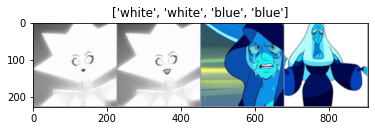

In [20]:
# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Step 3: Training the model

### Define the function to implement training and evaluating the model

In [21]:
training_loss = []
test_loss = []

training_accuracy = []
test_accuracy = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time() # To measure time taken to build and train the model

  best_model_wts = copy.deepcopy(model.state_dict()) # Save weight of best model
  best_acc = 0.0 # Save best accuracy

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has its training and validation
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloader[phase]:
        inputs = inputs.to(device) # Move data to GPU if you are using GPU
        labels = labels.to(device) # Move data to GPU if you are using GPU

        optimizer.zero_grad() # Set gradients to zero so it does not accumulate

        with torch.set_grad_enabled(phase == 'train'): # Train in train phase
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels) # Compare ground truth with outputs

          # Backward propagation if in train mode
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # Compute loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        
        
        running_corrects += torch.sum(preds == labels.data)

      if phase =='train':
        scheduler.step()

      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      if phase == 'train':
        training_loss.append(epoch_loss)
        training_accuracy.append(epoch_acc)
      else:
        test_loss.append(running_loss)
        test_accuracy.append(epoch_acc)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts) # Load the best model weights
  return model

### Finetuning the model we choose to use

In [22]:
model_ft = models.resnet18(pretrained=True) # Choose a model to use
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0517 Acc: 0.5870
val Loss: 0.5996 Acc: 0.6800

Epoch 1/24
----------
train Loss: 0.7001 Acc: 0.7500
val Loss: 0.4277 Acc: 0.8800

Epoch 2/24
----------
train Loss: 0.3601 Acc: 0.8804
val Loss: 0.1266 Acc: 0.9400

Epoch 3/24
----------
train Loss: 0.3961 Acc: 0.8478
val Loss: 0.0658 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.4953 Acc: 0.8587
val Loss: 0.4732 Acc: 0.8800

Epoch 5/24
----------
train Loss: 0.3728 Acc: 0.8370
val Loss: 0.1122 Acc: 0.9800

Epoch 6/24
----------
train Loss: 0.1752 Acc: 0.9457
val Loss: 0.3727 Acc: 0.8600

Epoch 7/24
----------
train Loss: 0.2768 Acc: 0.9457
val Loss: 0.2041 Acc: 0.8800

Epoch 8/24
----------
train Loss: 0.0882 Acc: 0.9674
val Loss: 0.1215 Acc: 0.9600

Epoch 9/24
----------
train Loss: 0.2635 Acc: 0.9457
val Loss: 0.0928 Acc: 0.9800

Epoch 10/24
----------
train Loss: 0.2503 Acc: 0.9348
val Loss: 0.1371 Acc: 0.9600

Epoch 11/24
----------
train Loss: 0.1253 Acc: 0.9783
val Loss: 0.1829 Acc: 0.8800

Ep

## Step 4: Visualizing the results

### Setup function to visualize results of the model

In [24]:
def visualize_model(model, num_images=6):
  was_training = model.training

  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloader['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)

        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return

    model.train(mode=was_training)

### Show model predictions

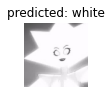

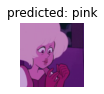

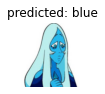

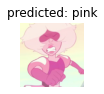

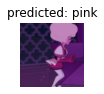

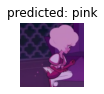

In [25]:
visualize_model(model_ft)
plt.ioff()
plt.show()

## Step 5: Plot the graph for accuracy and loss

### Training and test loss

Text(0, 0.5, 'negative log likelihood loss')

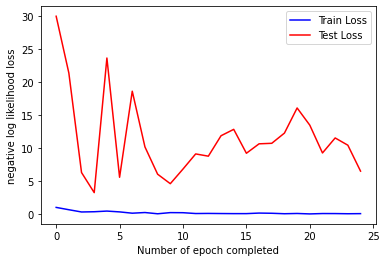

In [26]:
fig = plt.figure()
plt.plot(training_loss, color='blue')
plt.plot(test_loss, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Number of epoch completed')
plt.ylabel('negative log likelihood loss')

### Training and test accuracy

Text(0, 0.5, 'negative log likelihood loss')

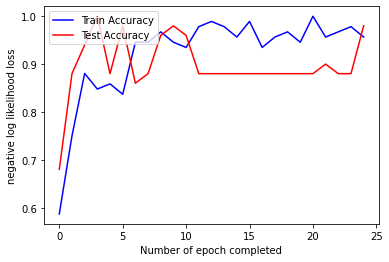

In [27]:
fig = plt.figure()
plt.plot(training_accuracy, color='blue')
plt.plot(test_accuracy, color='red')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.xlabel('Number of epoch completed')
plt.ylabel('negative log likelihood loss')

## Step 6: Plotting the confusion matrix

In [28]:
@torch.no_grad() # this functions execution omits gradient tracking.
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).cuda()
    for batch in loader:
        images, labels = batch
        images, labels = images.cuda(), labels.cuda() 

        preds = model(images)
        preds = preds.cuda()
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [29]:
all_preds = get_all_preds(model_ft, test_dataloader)
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)
    test_preds = get_all_preds(model_ft, prediction_loader)

In [30]:
def get_pred_as_list(test_preds):
  test_preds = (test_preds.max(1, keepdim=True)[1]).tolist()

  result = []
  for i in range(len(test_preds)):
    result.append(test_preds[i][0])

  return result

In [31]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
test_preds = get_pred_as_list(test_preds)

In [33]:
accuracy_score = accuracy_score(test_preds, test_dataset.targets)
print('Accuracy score: {0:0.2f}'.format(accuracy_score))

Accuracy score: 1.00


Confusion matrix, without normalization
tensor([[12,  0,  0,  0],
        [ 0, 13,  0,  0],
        [ 0,  0, 13,  0],
        [ 0,  0,  0, 12]])


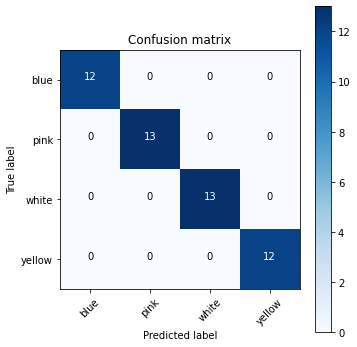

In [34]:
cmt = torch.zeros(len(class_names),len(class_names), dtype=torch.int64)
for i in range(len(test_preds)):
  tl = test_dataset.targets[i]
  pl = test_preds[i]

  cmt[tl, pl] = cmt[tl, pl] + 1

plt.figure(figsize=(5,5))
plot_confusion_matrix(cmt, test_dataset.classes)

### Predict an Image

In [37]:
import PIL

transform = data_transforms_with_normalization['val']

PATH_TO_IMAGE = '/content/test1.jpg'
img = PIL.Image.open(PATH_TO_IMAGE)  # Load image as PIL.Image
x = transform(img)  # Preprocess image
x = x.unsqueeze(0).cuda()  # Add batch dimension

output = model_ft(x)  # Forward pass
pred = torch.argmax(output, 1)  # Get predicted class if multi-class classification
im = PIL.Image.open(PATH_TO_IMAGE)
im.show()
print('Image predicted as ', class_names[pred.item()])

Image predicted as  pink


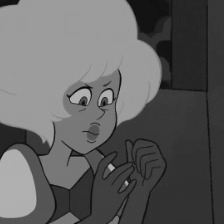

In [38]:
from IPython.display import Image, display
display(Image(PATH_TO_IMAGE))
